# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
# !pip install ydata_profiling

In [2]:
import re
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from phik import report

from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet,
    Ridge
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    TargetEncoder
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error as MSE

random.seed(42)
np.random.seed(42)

pd.set_option('display.max_columns', None)
%matplotlib inline

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

`Your answer here` Сиды фиксируем для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [4]:
df_test.to_csv('test_df.csv', index=False)

### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [v] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [v] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [v] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [v] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [5]:
# Посмотрим на пропуски в train
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [6]:
# Посмотрим на дубликаты в train
df_train[df_train.duplicated()]

name  year  selling_price  \
254                   Hyundai Grand i10 Sportz  2017         450000   
258                           Maruti Swift VXI  2012         330000   
324   Jaguar XE 2016-2019 2.0L Diesel Prestige  2017        2625000   
325                              Lexus ES 300h  2019        5150000   
326             Jaguar XF 2.0 Diesel Portfolio  2017        3200000   
...                                        ...   ...            ...   
6880             Renault Captur 1.5 Diesel RXT  2018        1265000   
6881                  Maruti Ciaz Alpha Diesel  2019        1025000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner     mileage  \
254       35000  Petrol  Individual       Manual   First Owner   18.9 kmpl   
258       50000  Petrol  Individual       Manual  Second Owner   18.6 kmpl   
324        9000  Diesel      Dealer    Automatic   First Owner   13.6 kmpl   
325       20000  Petrol      Dealer    Automatic   First Owner  22.37 kmpl   
326       45000  Diesel      Dealer    Automatic   First Owner  19.33 kmpl   
...         ...     ...         ...          ...           ...         ...   
6880      12000  Diesel  Individual       Manual   First Owner  20.37 kmpl   
6881      32000  Diesel  Individual       Manual   First Owner  28.09 kmpl   
6989      50000  Diesel  Individual       Manual   First Owner  26.59 kmpl   
6997      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   
6998      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   

       engine   max_power               torque  seats  
254   1197 CC      82 bhp       114Nm@ 4000rpm    5.0  
258   1197 CC    85.8 bhp       114Nm@ 4000rpm    5.0  
324   1999 CC     177 bhp  430Nm@ 1750-2500rpm    5.0  
325   2487 CC  214.56 bhp  202Nm@ 3600-5200rpm    5.0  
326   1999 CC     177 bhp  430Nm@ 1750-2500rpm    5.0  
...       ...         ...                  ...    ...  
6880  1461 CC  108.45 bhp       240Nm@ 1750rpm    5.0  
6881  1248 CC   88.50 bhp       200Nm@ 1750rpm    5.0  
6989  1248 CC      74 bhp       190Nm@ 2000rpm    5.0  
6997  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  
6998  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  

[985 rows x 13 columns]

**Ваш ответ здесь.**

In [7]:
profile = ProfileReport(df_train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 15740.75it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

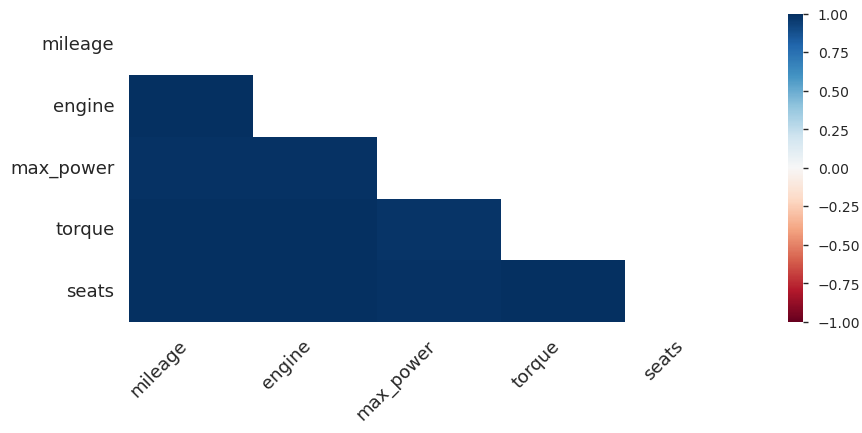

In [8]:
profile

`answer`

- 1005 пропущенных значений, 493 строки полностью задублировано, что составляет 7% от всего train датасета. Датасет состоит из 5 текстовых признаков, 4 числовых и 4 категориальных признака.  
- В признаке `selling_price` есть значение 10_000_000, что может являться выбросом. Также в `km_driven` значение 2_360_457 скорее всего тоже выброс.  
- Есть дисбаланс в признаках `fuel`, `seller_type`, `transmission`, `owner`.   
- Высокая отрицательная корреляция между признаками `year` и `km_driven`, `selling_price` и `km_driven`.
- Высокая положительная корреляция между признаками `selling_price` и `year`, `selling_price` и `transmission`, `selling_price` и `transmission`.


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [v] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [v] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [v] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [v] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [9]:
# Статистики по числовым столбцам
df_train.describe(include=['number'])

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [10]:
df_test.describe(include=['number'])

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [11]:
# Статистики по категориальным столбцам
df_train.describe(include=['object'])

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [12]:
df_test.describe(include=['object'])

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

`answer`

- Признак `year`. Средние значения меньше, чем медиана, это значит, что распределение чуть смещено, в выборке есть и старые и новые автомобили, и более старых автомобилей больше. В трейне чуть больше новых автомобилей, чем в тесте.
- По признаку `selling_price` среднее значительно выше медианы и в трейн и в тест,  это указывает асимметрия в распределении, в данных есть очень дорогие автомобили, из-за чего среднее выше медианы.
Средние и медиана в трейн выборке выше, чем в тестовой, значит в трейне есть более дорогие атомобили.
- По признаку `km_driven` так же среднее выше, чем медиана, но не сильно выше, это значит что ассиметрия в данных не настолько большая, в выборке есть немного автомобилей с большим пробегом.
В тестовой выборке значения среднего и медианы чуть выше.  
- Средние значения и медиана по признаку `seats` практически не отличаются, среднее чуть выше, т.к. автомобилей с сиденьями больше 5 не очень много. Значения в трейне и в тесте одинаковы.

### **Задание 3 (0.2 балла)**

- [v] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [v] Отобразите такие объекты (0.01 балла)
- [v] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [v]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [v] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [13]:
feature_columns = [col for col in df_train.columns if col != 'selling_price']
df_train[feature_columns].duplicated(keep=False).sum(), df_train[feature_columns].duplicated(keep='first').sum()

(1799, 1159)

`answer`

1799 всего строк объектов с дубликатами. Если считать дубликаты без первого вхождения по всем признакам, то получим 1159 строк (т.е. это количество строк, которое можно удалить).

In [14]:
df_train[df_train[feature_columns].duplicated(keep=False)].sort_values(by='name')

name  year  selling_price  km_driven  \
1703  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
6704               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
1836               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
117             Audi Q5 35TDI Premium Plus  2018        3975000      31800   
...                                    ...   ...            ...        ...   
3291        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
5753        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
1568        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
361         Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
2652        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   

        fuel seller_type transmission        owner     mileage   engine  \
1703  Diesel      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC   
6307  Diesel      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC   
6704  Diesel  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   
1836  Diesel  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   
117   Diesel      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC   
...      ...         ...          ...          ...         ...      ...   
3291  Diesel  Individual    Automatic  First Owner   18.0 kmpl  1969 CC   
5753  Diesel  Individual    Automatic  First Owner   18.0 kmpl  1969 CC   
1568  Diesel  Individual    Automatic  First Owner   18.0 kmpl  1969 CC   
361   Diesel  Individual    Automatic  First Owner   18.0 kmpl  1969 CC   
2652  Diesel  Individual    Automatic  First Owner   18.0 kmpl  1969 CC   

       max_power               torque  seats  
1703  174.33 bhp  380Nm@ 1750-2500rpm    5.0  
6307  174.33 bhp  380Nm@ 1750-2500rpm    5.0  
6704   241.4 bhp  580Nm@ 1400-3250rpm    5.0  
1836   241.4 bhp  580Nm@ 1400-3250rpm    5.0  
117      188 bhp  400nm@ 1750-3000rpm    5.0  
...          ...                  ...    ...  
3291     190 bhp                400Nm    5.0  
5753     190 bhp                400Nm    5.0  
1568     190 bhp                400Nm    5.0  
361      190 bhp                400Nm    5.0  
2652     190 bhp                400Nm    5.0  

[1799 rows x 13 columns]

In [15]:
df_train = df_train.drop_duplicates(subset=feature_columns, keep='first').reset_index(drop=True)
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

In [16]:
assert df_train.shape == (5840, 13)

`answer`

В трейне 1159 строк с одинаковым признаковым описанием.  
Могут быть скрытые дубликаты например в столбце `name` могуть быть записаны одни и те же марки автомобилей но по разному, например, с опечатками или на разных языках. Похожее так же может быть и в других признаках.  
Такие дубликаты сложно отлавливать, можно посмотреть уникальные значения в столбцах и так их отлавливать.

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [v] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [v] Приведите тип данных к ``float``.
* [v] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [17]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

In [18]:
for col in ['mileage', 'engine', 'max_power']:
    df_train[col] = df_train[col].str.replace(r'[^0-9.]', '', regex=True)
    df_test[col] = df_test[col].str.replace(r'[^0-9.]', '', regex=True)

In [19]:
df_train['max_power'].sort_values().unique()[:10]

array(['', '0', '100', '100.5', '100.57', '100.6', '101', '102', '102.5',
       '103'], dtype=object)

In [20]:
df_train['max_power'] = df_train['max_power'].replace('', np.nan)

In [21]:
df_train[['mileage', 'engine', 'max_power']] = df_train[['mileage', 'engine', 'max_power']].astype(float)
df_test[['mileage', 'engine', 'max_power']] = df_test[['mileage', 'engine', 'max_power']].astype(float)

In [22]:
df_train.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage          float64
engine           float64
max_power        float64
torque            object
seats            float64
dtype: object

In [23]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  \
0  Individual       Manual   First Owner    23.40  1248.0      74.00   
1  Individual       Manual  Second Owner    21.14  1498.0     103.52   
2  Individual       Manual   First Owner    23.00  1396.0      90.00   
3  Individual       Manual   First Owner    16.10  1298.0      88.20   
4  Individual       Manual   First Owner    20.14  1197.0      81.86   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения

In [24]:
def split_torque(torque):
    '''
    Функция делит столбец torque на два столбца (torque, max_torque_rpm), преобразует
    крутящий момент из 'kgm' в 'Nm' и избавляется от единиц измерения в столбце torque
    '''
    if not pd.isna(torque):
        try:
            if '@' in torque:
                parts = torque.split('@', 1)
                torque = parts[0].strip()
                max_torque_rpm = parts[1].strip()
            elif 'at' in torque:
                parts = torque.split('at', 1)
                torque = parts[0].strip()
                max_torque_rpm = parts[1].strip()
            
            # Преобразуем `kgm` в `Nm` и избавимся от единиц измерения
            if 'kgm' in torque.lower() or 'kgm' in max_torque_rpm.lower():
                torque = float(re.sub(r'[^\d.]', '', torque)) * 9.8
            elif 'nm' in torque.lower():
                torque = float(re.sub(r'[^\d.]', '', torque))
            else:
                torque = float(torque)
            return torque, max_torque_rpm
        except:
            return np.nan, np.nan
    else:
        return np.nan, np.nan

In [25]:
df_train[['torque', 'max_torque_rpm']] = df_train['torque'].apply(split_torque).apply(pd.Series)
df_test[['torque', 'max_torque_rpm']] = df_test['torque'].apply(split_torque).apply(pd.Series)

df_train['torque'] = df_train['torque'].astype(float)
df_test['torque'] = df_test['torque'].astype(float)

In [26]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  torque  \
0  Individual       Manual   First Owner    23.40  1248.0      74.00  190.00   
1  Individual       Manual  Second Owner    21.14  1498.0     103.52  250.00   
2  Individual       Manual   First Owner    23.00  1396.0      90.00  219.52   
3  Individual       Manual   First Owner    16.10  1298.0      88.20  112.70   
4  Individual       Manual   First Owner    20.14  1197.0      81.86  113.75   

   seats   max_torque_rpm  
0    5.0          2000rpm  
1    5.0     1500-2500rpm  
2    5.0     1750-2750rpm  
3    5.0  4,500(kgm@ rpm)  
4    5.0          4000rpm

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [v] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [v] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [v] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`

`answer`

- Если распределение признака смещено в лево или в право, то заполнение пропусков медианой не должно сильно повлиять на распределение признак т.к. она устойчива к выбросам и смещению распределения, если же мы заполним средним, то оно повлияет на распределение признака.  
- Правильно заполнять медианой посчитаной на тренировочном датасете, чтобы небыло утечки данных.

In [27]:
# your code here
# Заполним числовые признаки с пропусками медианой
for column in ['mileage', 'engine', 'max_power', 'seats', 'torque']:
    median = df_train[column].median()
    df_train[column] = df_train[column].fillna(median)
    df_test[column] = df_test[column].fillna(median)

# В столбце max_torque_rpm есть пропуски заполним их заглушкой 'N/A')
df_train['max_torque_rpm'] = df_train['max_torque_rpm'].fillna('N/A')
df_test['max_torque_rpm'] = df_test['max_torque_rpm'].fillna('N/A')

In [28]:
df_train.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [v] Осуществите приведение столбцов к необходимому типу.
- [v] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [29]:
# your code here
df_train[['seats', 'engine']] = df_train[['seats', 'engine']].astype(int)
df_test[['seats', 'engine']] = df_test[['seats', 'engine']].astype(int)

`answer`

Признак `seats` можно рассматривать как категориальную т.к. у нас всегда целое число сиденей в автомобиле. Так же есть зависимость количества сидений с типом кузова автомобиля, например у спортивных авто 2 сидения, у обычных автомобилей 5 сидений, у больших кроссоверов может быть 7 и т.д.


### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [v] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [30]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power         torque        seats  
count  5840.000000    5840.000000  5840.000000  
mean     87.906371     238.889759     5.426712  
std      31.640418    4876.920447     0.982344  
min       0.000000      47.040000     2.000000  
25%      68.000000     111.800000     5.000000  
50%      81.860000     160.000000     5.000000  
75%      99.000000     200.000000     5.000000  
max     400.000000  372779.260000    14.000000

`answer`

Распределения немного изменились в связи с тем, что мы удалили много дубликатов. Заполнение пропусков не повлияло на статистики, т.к. мы заполняли их медианой

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [v] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [v] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [v] Постройте pairplot по тестовым данным
- [v] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

<Figure size 640x480 with 0 Axes>

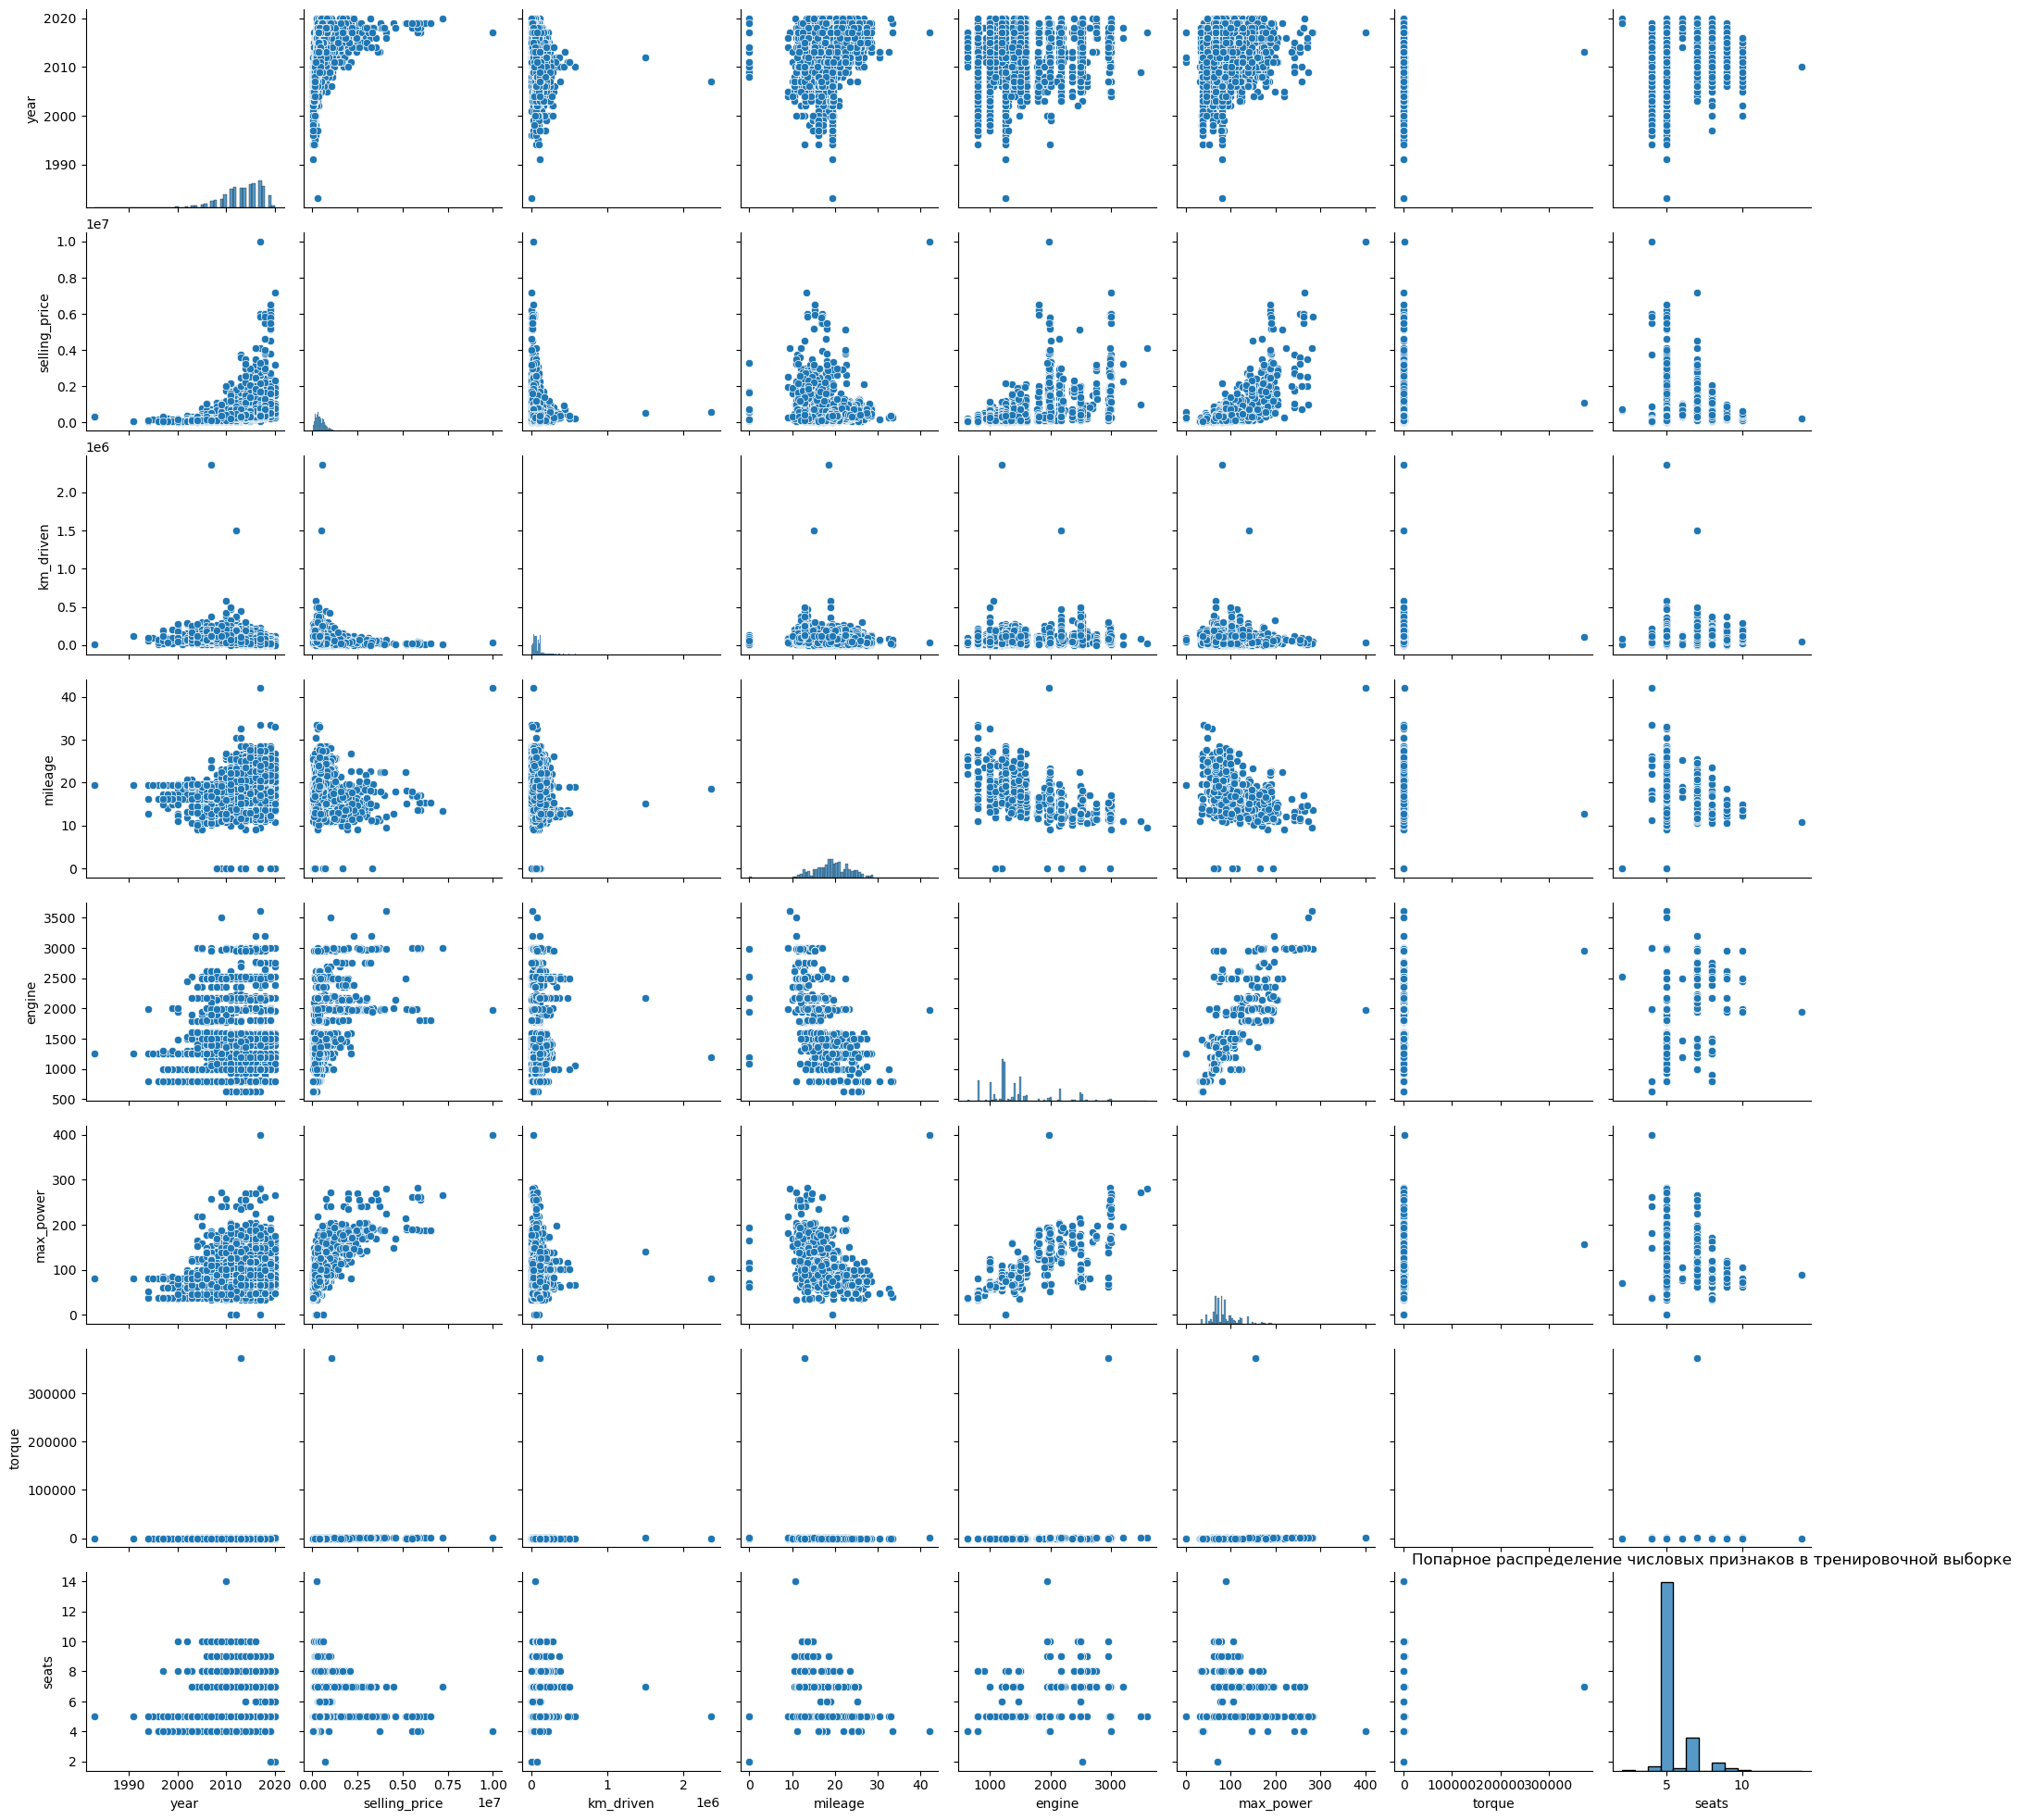

In [31]:
# your code here
plt.figure()
sns.pairplot(data=df_train)
plt.title("Попарное распределение числовых признаков в тренировочной выборке")
plt.show()

`answer`

 - Можно ли предположить на основе распределений связь признаков с целевой переменной?  
Ответ: можно, на графиках при пересечнии признака и целевого признака можно увидеть линейную зависимость, иногда можно увидеть, что-то типа экспоненциальной зависимости в данных или логарифмической. По некоторым признакам можно увидеть, что прямой связи с целевым признаком нет.

 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?  
Ответ: Да, можно увидеть положительную или отрицательную корреляцию, например в наших данных видна положительная корреляция между признаками `max_power` и `engine`, `selling_price` и `max_power`.

/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

<Figure size 640x480 with 0 Axes>

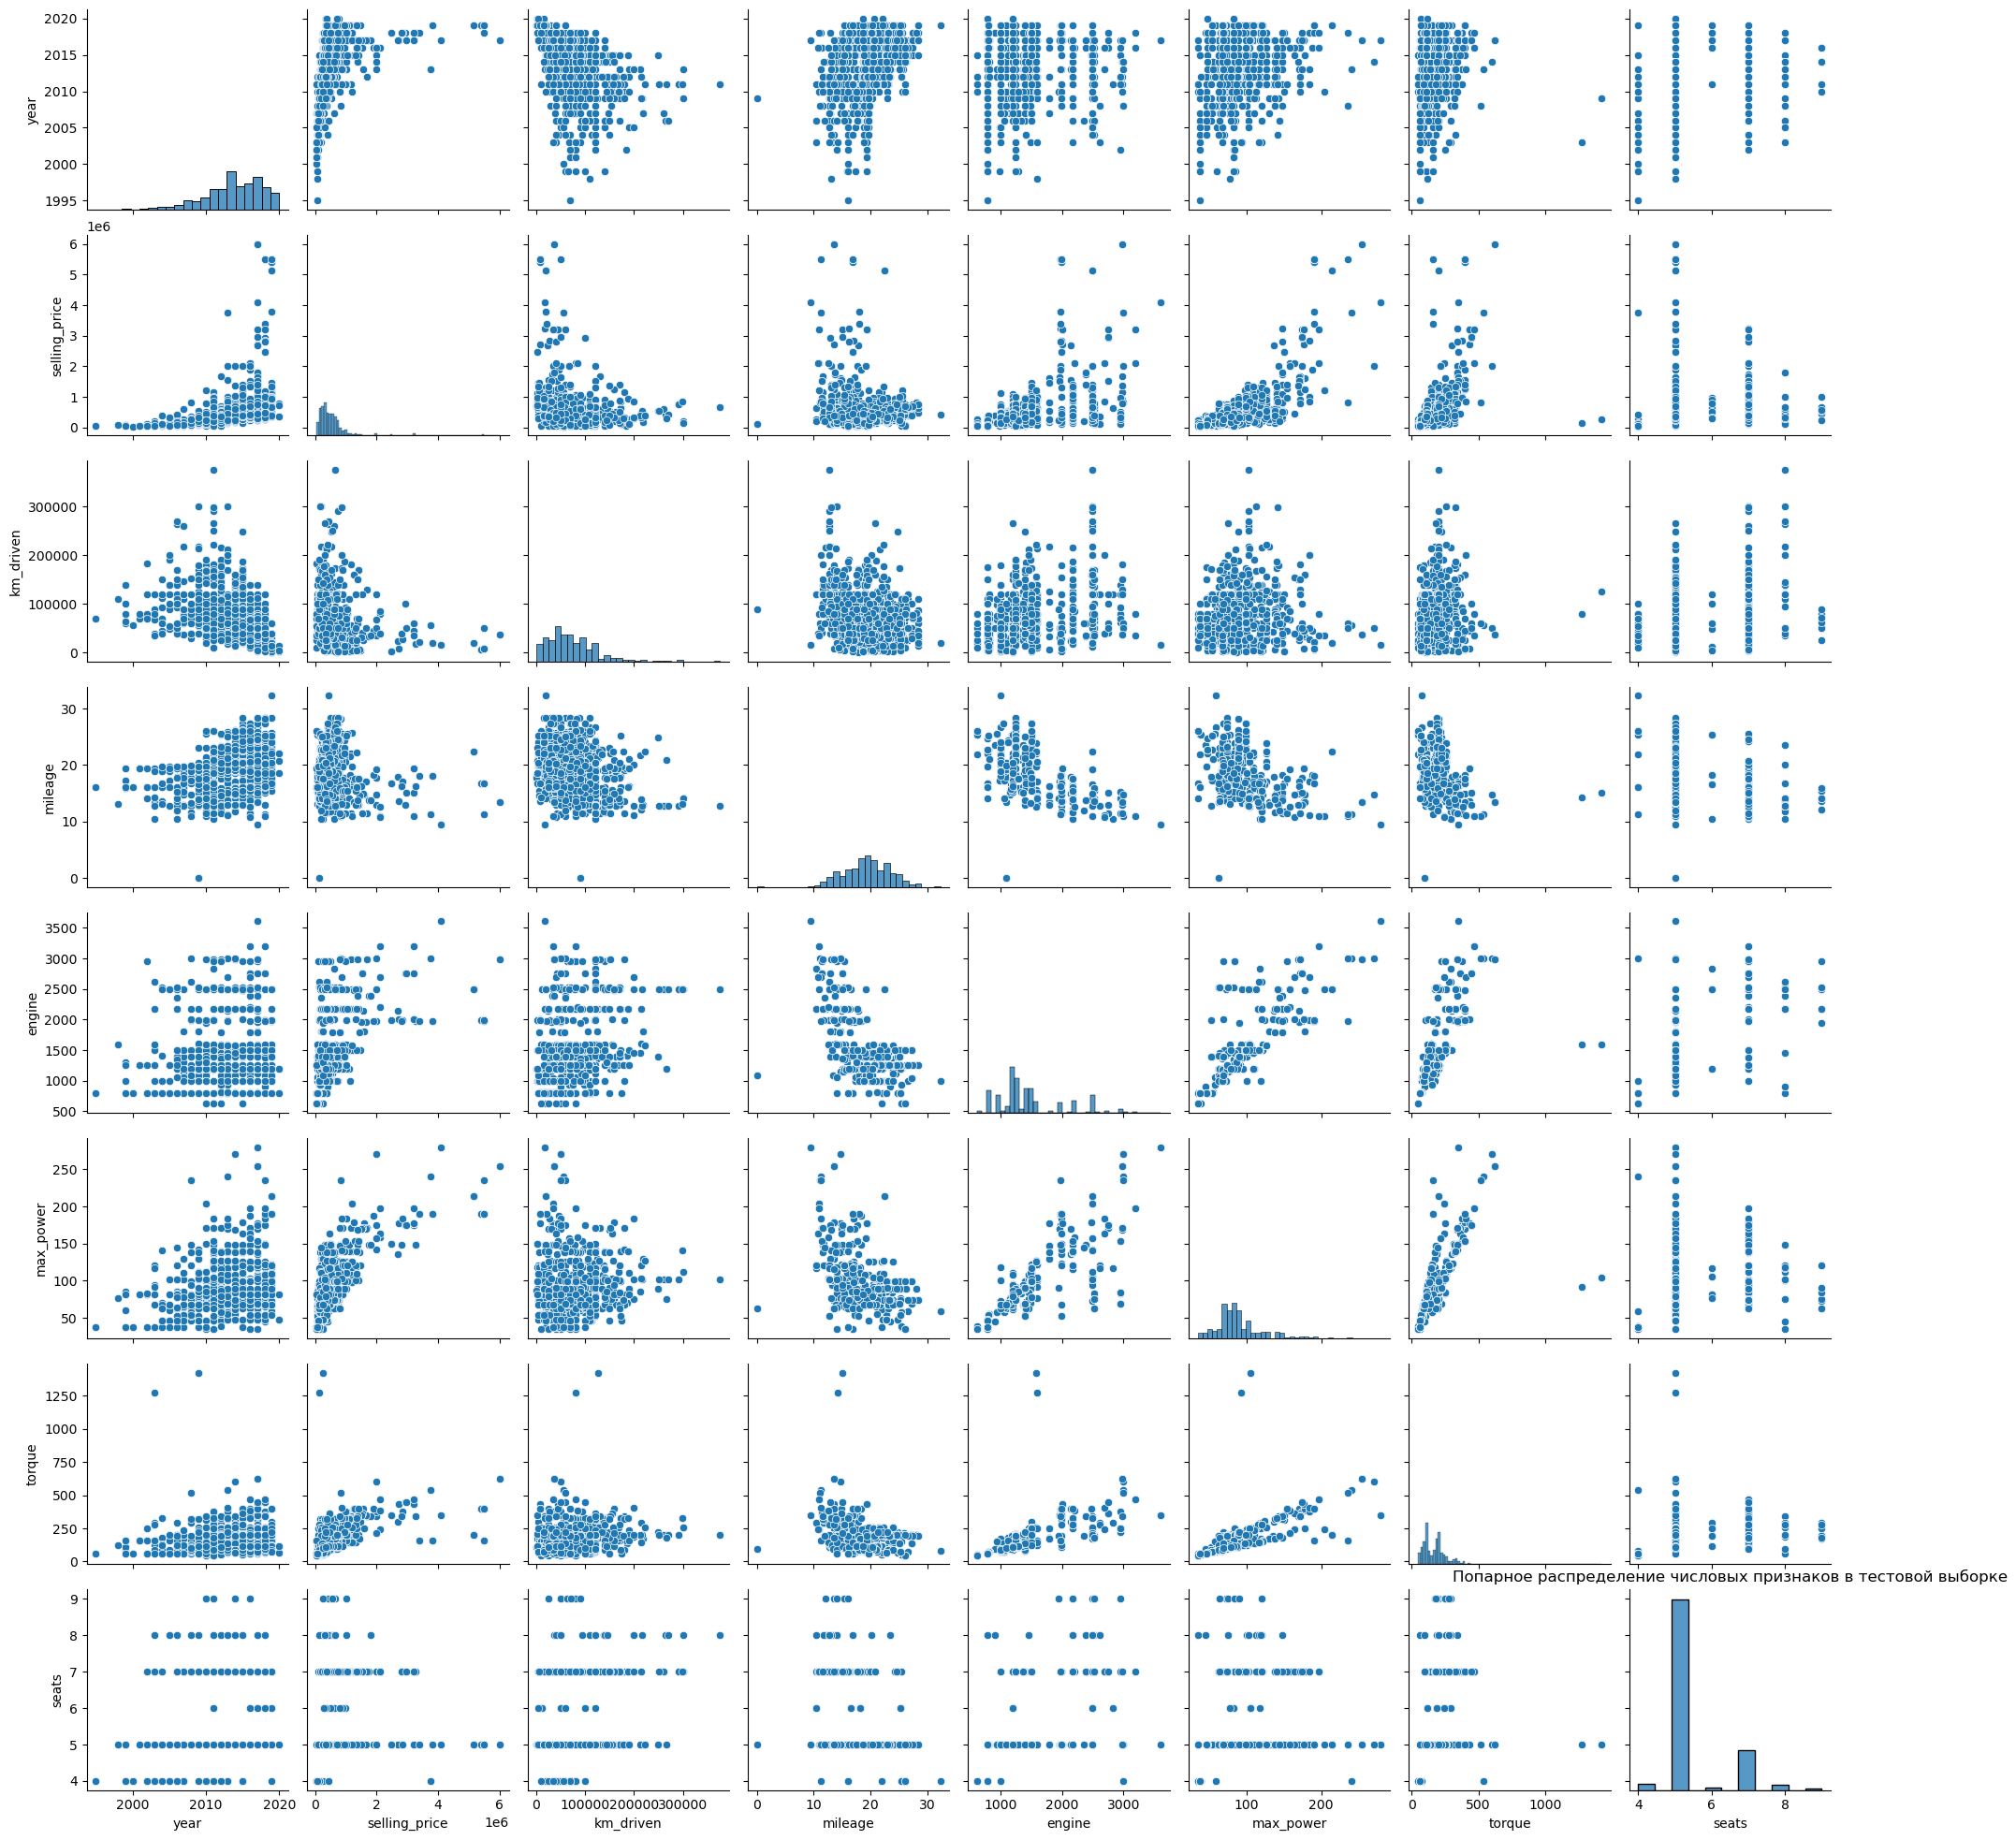

In [32]:
plt.figure()
sns.pairplot(data=df_test)
plt.title("Попарное распределение числовых признаков в тестовой выборке")
plt.show()

`answer`

Распределения данных в `df_train` и `df_test` в целом похожие, но в `df_train` есть большие выбросы, что осложняет сравнение тренировочной и тестовой выборки по `pairplot`

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [v] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [v] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [33]:
# your code here
corr_matrix = df_train.corr(numeric_only=True)
corr_matrix

year  selling_price  km_driven   mileage    engine  \
year           1.000000       0.427279  -0.368966  0.341334  0.002819   
selling_price  0.427279       1.000000  -0.164828 -0.104769  0.447672   
km_driven     -0.368966      -0.164828   1.000000 -0.182086  0.229766   
mileage        0.341334      -0.104769  -0.182086  1.000000 -0.572893   
engine         0.002819       0.447672   0.229766 -0.572893  1.000000   
max_power      0.156858       0.692814   0.024588 -0.373390  0.681117   
torque        -0.000209       0.023546   0.010335 -0.026921  0.054154   
seats          0.041178       0.149953   0.192328 -0.451059  0.652172   

               max_power    torque     seats  
year            0.156858 -0.000209  0.041178  
selling_price   0.692814  0.023546  0.149953  
km_driven       0.024588  0.010335  0.192328  
mileage        -0.373390 -0.026921 -0.451059  
engine          0.681117  0.054154  0.652172  
max_power       1.000000  0.042563  0.244112  
torque          0.042563  1.000000  0.027912  
seats           0.244112  0.027912  1.000000

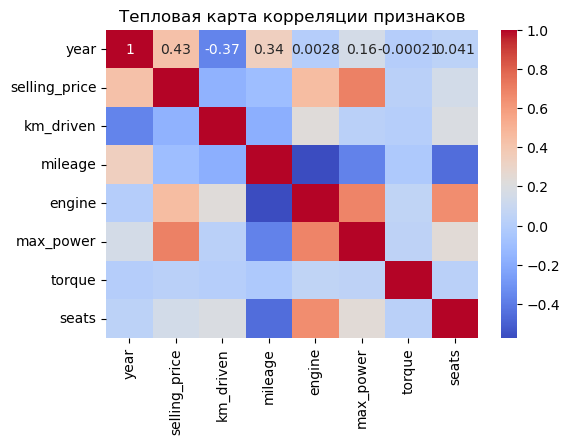

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Тепловая карта корреляции признаков")
plt.show()

- [v] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

`answer`

- Наименее скоррелированные признаки между собой это `torque` и `year`  
- Довольна сильная положительная линейная зависимость наблюдается между признаками `max_power` и `selling_price`, `max_power` и `engine`, `engine` и `seats`, `selling_price` и `year`, `selling_price` и `engine`
- Да, такая зависимость в данных есть, чем старше машина, тем больше у нее пробег
- В `pd.corr` по дефолту используется корреляция Пирсона (я пользовался ей), так же можно посчитать корреляцию Кендала и Спирмена (из документации pandas)

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [v] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [v] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [v] Проинтерпретируйте результаты


In [35]:
# Корреляция Спирмена
def spearman_corr(x, y):
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))
    return np.corrcoef(x_rank, y_rank)[0, 1]

def spearman_corr_matrix(df):
    num_df = df.select_dtypes(include='number')
    cols = num_df.columns
    matrix = pd.DataFrame(np.eye(num_df.shape[1]), index=cols, columns=cols)
    for i in cols:
        for j in cols:
            correlation = spearman_corr(df[i], df[j])
            matrix.loc[i, j] = correlation
            matrix.loc[j, i] = correlation
    return matrix

matrix_spearman = spearman_corr_matrix(df_train)
matrix_spearman

year  selling_price  km_driven   mileage    engine  \
year           1.000000       0.705060  -0.566218  0.342960 -0.034677   
selling_price  0.705060       1.000000  -0.295699  0.026164  0.461866   
km_driven     -0.566218      -0.295699   1.000000 -0.197687  0.303411   
mileage        0.342960       0.026164  -0.197687  1.000000 -0.428987   
engine        -0.034677       0.461866   0.303411 -0.428987  1.000000   
max_power      0.166875       0.612352   0.040464 -0.308684  0.711526   
torque         0.110450       0.583215   0.237851 -0.153759  0.834985   
seats          0.050485       0.220670   0.105454 -0.307221  0.361660   

               max_power    torque     seats  
year            0.166875  0.110450  0.050485  
selling_price   0.612352  0.583215  0.220670  
km_driven       0.040464  0.237851  0.105454  
mileage        -0.308684 -0.153759 -0.307221  
engine          0.711526  0.834985  0.361660  
max_power       1.000000  0.777297  0.200687  
torque          0.777297  1.000000  0.283711  
seats           0.200687  0.283711  1.000000

In [36]:
df_train.corr(method='spearman', numeric_only=True)

year  selling_price  km_driven   mileage    engine  \
year           1.000000       0.707123  -0.569659  0.346132 -0.038056   
selling_price  0.707123       1.000000  -0.295665  0.026186  0.463577   
km_driven     -0.569659      -0.295665   1.000000 -0.198466  0.304504   
mileage        0.346132       0.026186  -0.198466  1.000000 -0.429871   
engine        -0.038056       0.463577   0.304504 -0.429871  1.000000   
max_power      0.165798       0.612258   0.040919 -0.308824  0.713113   
torque         0.107988       0.583078   0.239196 -0.153556  0.837459   
seats          0.048291       0.317605   0.195317 -0.435458  0.527716   

               max_power    torque     seats  
year            0.165798  0.107988  0.048291  
selling_price   0.612258  0.583078  0.317605  
km_driven       0.040919  0.239196  0.195317  
mileage        -0.308824 -0.153556 -0.435458  
engine          0.713113  0.837459  0.527716  
max_power       1.000000  0.778400  0.304857  
torque          0.778400  1.000000  0.434809  
seats           0.304857  0.434809  1.000000

`answer`

Матрицы корреляций по некоторым признакам отличаются, т.к. реализация в pandas отличается от моей.

In [37]:
corr_phik_matrix = df_train.phik_matrix()
corr_phik_matrix

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']


/Users/ilshathaziev/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


name      year  selling_price  km_driven      fuel  \
name            1.000000  0.948995       0.994871   0.000000  1.000000   
year            0.948995  1.000000       0.219841   0.081574  0.205834   
selling_price   0.994871  0.219841       1.000000   0.000000  0.157885   
km_driven       0.000000  0.081574       0.000000   1.000000  0.046285   
fuel            1.000000  0.205834       0.157885   0.046285  1.000000   
seller_type     0.799127  0.232412       0.334505   0.000000  0.050771   
transmission    1.000000  0.153714       0.463058   0.012824  0.053721   
owner           0.830098  0.418636       0.557641   0.087887  0.030943   
mileage         0.999690  0.279253       0.649768   0.081625  0.582304   
engine          1.000000  0.213156       0.503682   0.210747  0.644421   
max_power       0.997906  0.381639       0.872166   0.000000  0.236006   
torque          1.000000  0.000000       0.040497   0.000000  0.000000   
seats           0.999985  0.288178       0.196447   0.096223  0.450714   
max_torque_rpm  0.999994  0.706551       0.905178   0.327821  0.835277   

                seller_type  transmission     owner   mileage    engine  \
name               0.799127      1.000000  0.830098  0.999690  1.000000   
year               0.232412      0.153714  0.418636  0.279253  0.213156   
selling_price      0.334505      0.463058  0.557641  0.649768  0.503682   
km_driven          0.000000      0.012824  0.087887  0.081625  0.210747   
fuel               0.050771      0.053721  0.030943  0.582304  0.644421   
seller_type        1.000000      0.127968  0.176612  0.064736  0.160346   
transmission       0.127968      1.000000  0.096990  0.331889  0.520161   
owner              0.176612      0.096990  1.000000  0.152406  0.186011   
mileage            0.064736      0.331889  0.152406  1.000000  0.588155   
engine             0.160346      0.520161  0.186011  0.588155  1.000000   
max_power          0.331904      0.511877  0.121438  0.687235  0.720780   
torque             0.000000      0.022241  0.029999  0.000000  0.122578   
seats              0.032173      0.045734  0.046741  0.679979  0.603400   
max_torque_rpm     0.389776      0.598784  0.783880  0.913501  0.947529   

                max_power    torque     seats  max_torque_rpm  
name             0.997906  1.000000  0.999985        0.999994  
year             0.381639  0.000000  0.288178        0.706551  
selling_price    0.872166  0.040497  0.196447        0.905178  
km_driven        0.000000  0.000000  0.096223        0.327821  
fuel             0.236006  0.000000  0.450714        0.835277  
seller_type      0.331904  0.000000  0.032173        0.389776  
transmission     0.511877  0.022241  0.045734        0.598784  
owner            0.121438  0.029999  0.046741        0.783880  
mileage          0.687235  0.000000  0.679979        0.913501  
engine           0.720780  0.122578  0.603400        0.947529  
max_power        1.000000  0.020906  0.569587        0.974470  
torque           0.020906  1.000000  0.000000        0.000000  
seats            0.569587  0.000000  1.000000        0.939052  
max_torque_rpm   0.974470  0.000000  0.939052        1.000000

`answer`

1. Очень большая корреляция между признаком `name` и всеми остальными признаками, видимо в названии уже заложено очень много информации об автомобиле, корреляция с ценой 0.99.
2. Сильная корреляция между `selling_price` и признаками `max_power` и `max_torque_rpm`.
3. Нет корреляции между `selling_price` и `km_driven`, что очень странно. Cлабая корреляция между `selling_price` и `torque`.

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

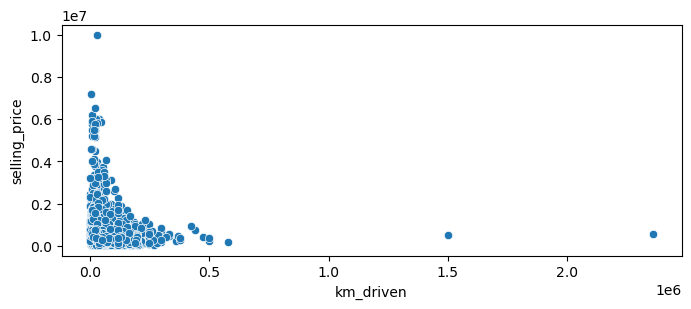

In [38]:
# Посмотрим зависимость цены от пробега, т.к. по phik нет корреляции между признаками, что странно
plt.figure(figsize=(8, 3))
sns.scatterplot(data=df_train, x='km_driven', y='selling_price')
plt.show()

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [39]:
numeric_train = df_train.copy()
numeric_train = numeric_train.select_dtypes(include='number')

y_train = numeric_train['selling_price']
X_train = numeric_train.drop('selling_price', axis=1)

`answer`

Вещественные признаки - это все числовые признаки, т.е `year`, `km_driven`, `mileage`, `engine`, `max_power`, `torque`, `seats`


In [40]:
numeric_test = df_test.copy()
numeric_test = numeric_test.select_dtypes(include='number')

y_test = numeric_test['selling_price']
X_test = numeric_test.drop('selling_price', axis=1)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [v] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [v] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [41]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

test_preds = model_lr.predict(X_test)
train_preds = model_lr.predict(X_train)

r2_test = r2_score(y_test, test_preds)
mse_test = MSE(y_test, test_preds)

r2_train = r2_score(y_train, train_preds)
mse_train = MSE(y_train, train_preds)

print(f"""Метрики для тестовой выборки:
    MSE = {mse_test:.3f}, R2 = {r2_test:.3f}, RMSE = {np.sqrt(mse_test):.3f}
Метрики для тренировочной выборки:
    MSE = {mse_train:.3f}, R2 = {r2_train:.3f}, RMSE = {np.sqrt(mse_train):.3f}""")

Метрики для тестовой выборки:
    MSE = 233275442006.476, R2 = 0.594, RMSE = 482985.965
Метрики для тренировочной выборки:
    MSE = 116867713415.783, R2 = 0.592, RMSE = 341859.201


In [42]:
y_test.mean(), y_test.median()

(617901.042, 434999.0)

`answer`  

Модель объясняет 59% процентов диспериссии целевой переменной, остальные 41% модель не смогла учесть, в целом модель работает гораздо лучше, чем предсказание среднего значения по выборке, но все же по $R^2$ модель не достаточно хорошая.  
По MSE ошибка для тестовой выборки хуже, скорее всего на некоторых данных модель очень сильно ошибается, что затягивает MSE к большим значениям.  
Вывел RMSE для удобства, видно, что среднее значение ошибки по тестовой выборек 482 тыс., при том, что медианное значение в тестовой выборке 434999, а среднее 617901, можно сделать вывод, что модель сильно ошибается в прогнозах.  
Возможно, есть небольшое переобучение модели, если судить по MSE.

### **Задание 13 (0.15 балла)**

- [v] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики.

In [43]:
def r2(X, y):
    X = np.array(X)
    y = np.array(y)
    sse = np.sum((y - X) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    return 1 - sse / sst

r2(test_preds, y_test) == r2_test

True

`answer`
$$
R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - f(x_i))^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}
$$

где:
- $y_i$ - истинное значение
- $f(x_i)$ - прогнозы модели
- $\bar{y}$ - среднее значение по всем истинным значениям

Сумма квадратов ошибок модели по всем предсказаниям делится на сумму квадратов истинных значений с вычетом среднего по всем истинным значениям, и все это вычитается из 1.  
Если $R^2$ равно 1, то это идеальная модель, если 0 - модель не лучше среднего значения, если меньше нуля - модель предсказывает хуже среднего значения.

### **Бонус (0.15 балла)**

- [v] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [v] Объясните, когда применяется $\text{adjusted}-R^2$?

In [44]:
# your code here
def r2_adjusted(true, pred, n, k):
    '''
    true - инстинные значения
    pred - прогнозы
    n - количество наблюдений
    k - кол-во независимых переменных модели
    '''
    r2_score = r2(pred, true) # реализовал на прошлом шаге
    return 1 - ((1 - r2_score) * (n - 1) / (n - k -1))

`answer`

Используется когда нужно сравнить две модели с разным числом признаков, т.к. $R^2$ растет или не увеличивается при добавлении в модель дополнительных признаков, из-за чего с помощью $R^2$ некорректно сравнивать модели с разным количеством признаков.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [v] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [45]:
scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

model_lr.fit(X_train, y_train)

test_preds = model_lr.predict(X_test)
train_preds = model_lr.predict(X_train)

r2_test = r2_score(y_test, test_preds)
mse_test = MSE(y_test, test_preds)

r2_train = r2_score(y_train, train_preds)
mse_train = MSE(y_train, train_preds)

print(f"""Метрики для тестовой выборки:
    MSE = {mse_test:.3f}, R2 = {r2_test:.3f}, RMSE = {np.sqrt(mse_test):.3f}
Метрики для тренировочной выборки:
    MSE = {mse_train:.3f}, R2 = {r2_train:.3f}, RMSE = {np.sqrt(mse_train):.3f}""")

Метрики для тестовой выборки:
    MSE = 233275442006.470, R2 = 0.594, RMSE = 482985.965
Метрики для тренировочной выборки:
    MSE = 116867713415.784, R2 = 0.592, RMSE = 341859.201


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [v] Какой признак оказался наиболее информативным в предсказании цены?

In [46]:
# your code 
weights = pd.DataFrame(index=model_lr.feature_names_in_, data=model_lr.coef_, columns=['weights'])
weights.sort_values(by='weights', ascending=False)

weights
max_power  322827.347746
year       152761.371996
engine      61328.459467
mileage     28851.707091
torque      -2541.730051
seats      -23231.371514
km_driven  -44164.114129

`answer`

Наибольший коэффициент по модулю у признака `max_power`, т.е. этот признак оказался наиболее информативным в предсказании цены автомобиля.

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [v] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [v] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [47]:
model_lasso = Lasso()

model_lasso.fit(X_train, y_train)

test_preds = model_lasso.predict(X_test)
train_preds = model_lasso.predict(X_train)

r2_test = r2_score(y_test, test_preds)
mse_test = MSE(y_test, test_preds)

r2_train = r2_score(y_train, train_preds)
mse_train = MSE(y_train, train_preds)

print(f"""Метрики для тестовой выборки:
    MSE = {mse_test:.3f}, R2 = {r2_test:.3f}, RMSE = {np.sqrt(mse_test):.3f}
Метрики для тренировочной выборки:
    MSE = {mse_train:.3f}, R2 = {r2_train:.3f}, RMSE = {np.sqrt(mse_train):.3f}""")

Метрики для тестовой выборки:
    MSE = 233276122393.479, R2 = 0.594, RMSE = 482986.669
Метрики для тренировочной выборки:
    MSE = 116867713427.071, R2 = 0.592, RMSE = 341859.201


In [48]:
lasso_weights = pd.DataFrame(index=model_lasso.feature_names_in_, data=model_lasso.coef_, columns=['weights'])
lasso_weights.sort_values(by='weights', ascending=False)

weights
max_power  322828.222997
year       152761.196253
engine      61323.563142
mileage     28849.816905
torque      -2540.645660
seats      -23228.485066
km_driven  -44162.983121

`answer`

L-1 регуляризация не занулила веса, предполагаю, что это связано с тем, что нет сильного переобучения модели (видно при сравнении метрик на тестовой и обучающей выборке), и все признаки информативны для модели.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [v] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [v] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [49]:
# your code here
lasso = Lasso(random_state=42)
params = {
    'alpha': np.linspace(1, 1000, 21),
}

grid_search_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=params,
    cv=10,
    scoring='neg_mean_squared_error'
)

grid_search_lasso.fit(X_train, y_train)

print(f'''Лучшие параметры: {grid_search_lasso.best_params_}
Лучшая метрика MSE: {-grid_search_lasso.best_score_:.3f}
Лучшая метрика RMSE: {np.sqrt(-grid_search_lasso.best_score_):.3f}''')

Лучшие параметры: {'alpha': 1000.0}
Лучшая метрика MSE: 121304939650.637
Лучшая метрика RMSE: 348288.587


In [50]:
best_model = grid_search_lasso.best_estimator_
weights = pd.DataFrame(index=best_model.feature_names_in_, data=best_model.coef_, columns=['weights'])
weights.sort_values(by='weights', ascending=False)

weights
max_power  323678.326266
year       152549.891182
engine      56521.813603
mileage     27020.987867
torque      -1458.381040
seats      -20364.893138
km_driven  -43055.297811

`answer`

- `GridSearch`-у пришлось обучить 200 моделей.  
- `alpha` - коэффициент регуляризации
- самый лучший коэффициент регуляризации = 1000. Веса не занулились.

**Ваша задача 2:**

- [v] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [v] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [51]:
# your code here
model_elasticnet = ElasticNet(random_state=42)

params = {
    'alpha': np.linspace(1, 1000, 21),
    'l1_ratio': np.linspace(0.1, 1, 10),
}

grid_search_elasticnet = GridSearchCV(
    estimator=model_elasticnet,
    param_grid=params,
    cv=10,
    scoring='neg_mean_squared_error'
)

grid_search_elasticnet.fit(X_train, y_train)

print(f'''Лучшие параметры: {grid_search_elasticnet.best_params_}
Лучшая метрика MSE: {-grid_search_elasticnet.best_score_:.3f}
Лучшая метрика RMSE: {np.sqrt(-grid_search_elasticnet.best_score_):.3f}''')

Лучшие параметры: {'alpha': 1000.0, 'l1_ratio': 1.0}
Лучшая метрика MSE: 121304939650.637
Лучшая метрика RMSE: 348288.587


In [52]:
print(f'Лучшие параметры модели: {grid_search_elasticnet.best_params_}')

Лучшие параметры модели: {'alpha': 1000.0, 'l1_ratio': 1.0}


`answer`

- `GridSearch`-у пришлось обучить 2000 моделей.  
- Лучшие параметры модели: 'alpha': 1000.0, 'l1_ratio': 1.0

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [53]:
# your code here

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [v] Предобработайте столбец `name`, чтобы избежать его удаления

In [54]:
# your code here
# Оcтавлю вместо полного названия автомобиля, только марку производителя
df_train['marque'] = df_train['name'].str.lower().str.split(' ').str[0]
df_test['marque'] = df_test['name'].str.lower().str.split(' ').str[0]

In [55]:
df_train = df_train.drop('max_torque_rpm', axis=1)
df_test = df_test.drop('max_torque_rpm', axis=1)

In [56]:
X_train_cat = df_train.copy()
X_train_cat = X_train_cat.drop(['selling_price', 'name'], axis=1)

X_test_cat = df_test.copy()
X_test_cat = X_test_cat.drop(['selling_price', 'name'], axis=1)

In [57]:
X_train_cat.shape

(5840, 12)

In [58]:
X_train_cat.head()

year  km_driven    fuel seller_type transmission         owner  mileage  \
0  2014     145500  Diesel  Individual       Manual   First Owner    23.40   
1  2014     120000  Diesel  Individual       Manual  Second Owner    21.14   
2  2010     127000  Diesel  Individual       Manual   First Owner    23.00   
3  2007     120000  Petrol  Individual       Manual   First Owner    16.10   
4  2017      45000  Petrol  Individual       Manual   First Owner    20.14   

   engine  max_power  torque  seats   marque  
0    1248      74.00  190.00      5   maruti  
1    1498     103.52  250.00      5    skoda  
2    1396      90.00  219.52      5  hyundai  
3    1298      88.20  112.70      5   maruti  
4    1197      81.86  113.75      5  hyundai

In [59]:
# assert X_train_cat.shape == (5840, 11)

Не понятно из условия в итоге должно остаться 11 только категориальных или всего 11 признаков.

In [60]:
X_train_cat.describe(include='object')

fuel seller_type transmission        owner  marque
count     5840        5840         5840         5840    5840
unique       4           3            2            5      30
top     Diesel  Individual       Manual  First Owner  maruti
freq      3177        5223         5336         3603    1804

### **Задание 20 (0.1 балла)**

- [v] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [61]:
# your code here
column_to_ohe = list(X_train_cat.select_dtypes(include='object').columns)
column_to_ohe.append('seats')

ohe = OneHotEncoder(sparse_output=False, dtype='int', handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train_cat[column_to_ohe])
X_test_ohe = ohe.transform(X_test_cat[column_to_ohe])

ohe_colums = ohe.get_feature_names_out(column_to_ohe)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_colums, index=X_train_cat.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_colums, index=X_test_cat.index)

X_train_cat = pd.concat([X_train_ohe, X_train_cat.drop(column_to_ohe, axis=1)], axis=1)
X_test_cat = pd.concat([X_test_ohe, X_test_cat.drop(column_to_ohe, axis=1)], axis=1)

In [62]:
X_train_cat.shape, X_test_cat.shape

((5840, 59), (1000, 59))

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`answer`

1. Нужно обучать OHE на тренировочной, применять на тренировочной и тестовой. Чтобы небыло ошибок, если в тесте встретится новая категория, которой небыло в тренировочной выборке, нужно применять параметр `handle_unknown='ignore'`. Обычно OHE применяется когда не очень много категорий в признаке.
2. Удаляем один столбец, чтобы не попасть в дамми-ловушку.
3. Думаю, что не стоит так делать, т.к. этот признак может кодировать редкую категорию.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [v] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [v] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [63]:
# Отмасштабируем признаки
to_scale = ['year', 'km_driven', 'mileage', 'engine', 'max_power',	'torque']

X_train_cat_scaled = X_train_cat.copy()
X_test_cat_scaled = X_test_cat.copy()

scaler_cat = StandardScaler()
X_train_cat_scaled[to_scale] = pd.DataFrame(data=scaler_cat.fit_transform(X_train_cat[to_scale]), columns=to_scale)
X_test_cat_scaled[to_scale] = pd.DataFrame(data=scaler_cat.transform(X_test_cat[to_scale]), columns=to_scale)

In [64]:
X_train_cat_scaled.head()

fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Dealer  \
0         0            1         0            0                   0   
1         0            1         0            0                   0   
2         0            1         0            0                   0   
3         0            0         0            1                   0   
4         0            0         0            1                   0   

   seller_type_Individual  seller_type_Trustmark Dealer  \
0                       1                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       1                             0   

   transmission_Automatic  transmission_Manual  owner_First Owner  \
0                       0                    1                  1   
1                       0                    1                  0   
2                       0                    1                  1   
3                       0                    1                  1   
4                       0                    1                  1   

   owner_Fourth & Above Owner  owner_Second Owner  owner_Test Drive Car  \
0                           0                   0                     0   
1                           0                   1                     0   
2                           0                   0                     0   
3                           0                   0                     0   
4                           0                   0                     0   

   owner_Third Owner  marque_ambassador  marque_audi  marque_bmw  \
0                  0                  0            0           0   
1                  0                  0            0           0   
2                  0                  0            0           0   
3                  0                  0            0           0   
4                  0                  0            0           0   

   marque_chevrolet  marque_daewoo  marque_datsun  marque_fiat  marque_force  \
0                 0              0              0            0             0   
1                 0              0              0            0             0   
2                 0              0              0            0             0   
3                 0              0              0            0             0   
4                 0              0              0            0             0   

   marque_ford  marque_honda  marque_hyundai  marque_isuzu  marque_jaguar  \
0            0             0               0             0              0   
1            0             0               0             0              0   
2            0             0               1             0              0   
3            0             0               0             0              0   
4            0             0               1             0              0   

   marque_jeep  marque_kia  marque_land  marque_lexus  marque_mahindra  \
0            0           0            0             0                0   
1            0           0            0             0                0   
2            0           0            0             0                0   
3            0           0            0             0                0   
4            0           0            0             0                0   

   marque_maruti  marque_mercedes-benz  marque_mg  marque_mitsubishi  \
0              1                     0          0                  0   
1              0                     0          0                  0   
2              0                     0          0                  0   
3              1                     0          0                  0   
4              0                     0          0                  0   

   marque_nissan  marque_peugeot  marque_renault  marque_skoda  marque_tata  \
0              0               0             

In [65]:
# your code here
model_ridge = Ridge()

params = {
    'alpha': np.linspace(0, 100, 21)
}

grid_search_ridge = GridSearchCV(
    estimator=model_ridge,
    param_grid=params,
    cv=10,
    scoring='r2'
)

grid_search_ridge.fit(X_train_cat_scaled, y_train)

print(f'''Лучшие параметры: {grid_search_ridge.best_params_}
Лучшая метрика R2: {grid_search_ridge.best_score_:.3f}''')

Лучшие параметры: {'alpha': 10.0}
Лучшая метрика R2: 0.700


При сравнении с первой моделью, метрика R2 стала лучше

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [66]:
# добавим модель автомобиля к текущему датафрейму
df_train['model'] = df_train['name'].str.lower().str.split(' ').str[1]
df_test['model'] = df_test['name'].str.split(' ').str[1]

X_train_cat_fe = pd.concat([X_train_cat, df_train['model']], axis=1)
X_test_cat_fe = pd.concat([X_test_cat, df_test['model']], axis=1)

In [67]:
# Закодируем признак через TargetEncoder
encoder = TargetEncoder(target_type='continuous')

X_train_cat_fe['model'] = encoder.fit_transform(X_train_cat_fe[['model']], y_train)
X_test_cat_fe['model'] = encoder.transform(X_test_cat_fe[['model']])

In [68]:
# Посмотрим максимальный год пробега автомобиля
X_train_cat_fe['year'].max()

2020

In [69]:
# Посмотрим на статистики по пробегу для автомобилей с годом выпуска 2020
X_train_cat_fe[X_train_cat['year'] == X_train_cat_fe['year'].max()]['km_driven'].describe()

count        58.000000
mean      21869.017241
std       27193.116405
min        1000.000000
25%        5000.000000
50%       10000.000000
75%       28750.000000
max      120000.000000
Name: km_driven, dtype: float64

Исходя из того, что нет нулевых значений пробега, можно предположить что данные на 2020 или 2021 год. Будем считать, что 2021 год, чтобы в будущем небыло деления на ноль, при создании фичи среднего пробега за год.

In [70]:
# Сделаем фичу, возраст атомобиля в годах, будем
X_train_cat_fe['age'] = X_train_cat_fe['year'].apply(lambda x: 2021 - x)
X_test_cat_fe['age'] = X_test_cat_fe['year'].apply(lambda x: 2021 - x)

# Сделаем фичу средний пробег за год пробега
X_train_cat_fe['km_per_age'] = X_train_cat_fe['km_driven'] / X_train_cat_fe['age']
X_test_cat_fe['km_per_age'] = X_test_cat_fe['km_driven'] / X_test_cat_fe['age']

In [71]:
X_train_cat_fe.head()

fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Dealer  \
0         0            1         0            0                   0   
1         0            1         0            0                   0   
2         0            1         0            0                   0   
3         0            0         0            1                   0   
4         0            0         0            1                   0   

   seller_type_Individual  seller_type_Trustmark Dealer  \
0                       1                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       1                             0   

   transmission_Automatic  transmission_Manual  owner_First Owner  \
0                       0                    1                  1   
1                       0                    1                  0   
2                       0                    1                  1   
3                       0                    1                  1   
4                       0                    1                  1   

   owner_Fourth & Above Owner  owner_Second Owner  owner_Test Drive Car  \
0                           0                   0                     0   
1                           0                   1                     0   
2                           0                   0                     0   
3                           0                   0                     0   
4                           0                   0                     0   

   owner_Third Owner  marque_ambassador  marque_audi  marque_bmw  \
0                  0                  0            0           0   
1                  0                  0            0           0   
2                  0                  0            0           0   
3                  0                  0            0           0   
4                  0                  0            0           0   

   marque_chevrolet  marque_daewoo  marque_datsun  marque_fiat  marque_force  \
0                 0              0              0            0             0   
1                 0              0              0            0             0   
2                 0              0              0            0             0   
3                 0              0              0            0             0   
4                 0              0              0            0             0   

   marque_ford  marque_honda  marque_hyundai  marque_isuzu  marque_jaguar  \
0            0             0               0             0              0   
1            0             0               0             0              0   
2            0             0               1             0              0   
3            0             0               0             0              0   
4            0             0               1             0              0   

   marque_jeep  marque_kia  marque_land  marque_lexus  marque_mahindra  \
0            0           0            0             0                0   
1            0           0            0             0                0   
2            0           0            0             0                0   
3            0           0            0             0                0   
4            0           0            0             0                0   

   marque_maruti  marque_mercedes-benz  marque_mg  marque_mitsubishi  \
0              1                     0          0                  0   
1              0                     0          0                  0   
2              0                     0          0                  0   
3              1                     0          0                  0   
4              0                     0          0                  0   

   marque_nissan  marque_peugeot  marque_renault  marque_skoda  marque_tata  \
0              0               0             

Сделаем фичу объем на мощность и момент на мощность. Но в признаке `max_power` есть нулевые значения, что неверно. Заменим нули медианным значением максимальной мощности, для авто с таким же объемом двигателя.

In [72]:
X_train_cat_fe[X_train_cat_fe.max_power == 0]

fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Dealer  \
476          0            0         0            1                   0   
1112         0            1         0            0                   1   
2003         0            1         0            0                   0   

      seller_type_Individual  seller_type_Trustmark Dealer  \
476                        1                             0   
1112                       0                             0   
2003                       1                             0   

      transmission_Automatic  transmission_Manual  owner_First Owner  \
476                        0                    1                  1   
1112                       0                    1                  1   
2003                       0                    1                  1   

      owner_Fourth & Above Owner  owner_Second Owner  owner_Test Drive Car  \
476                            0                   0                     0   
1112                           0                   0                     0   
2003                           0                   0                     0   

      owner_Third Owner  marque_ambassador  marque_audi  marque_bmw  \
476                   0                  0            0           0   
1112                  0                  0            0           0   
2003                  0                  0            0           0   

      marque_chevrolet  marque_daewoo  marque_datsun  marque_fiat  \
476                  0              0              0            0   
1112                 0              0              0            0   
2003                 0              0              0            0   

      marque_force  marque_ford  marque_honda  marque_hyundai  marque_isuzu  \
476              0            0             0               0             0   
1112             0            0             0               0             0   
2003             0            0             0               0             0   

      marque_jaguar  marque_jeep  marque_kia  marque_land  marque_lexus  \
476               0            0           0            0             0   
1112              0            0           0            0             0   
2003              0            0           0            0             0   

      marque_mahindra  marque_maruti  marque_mercedes-benz  marque_mg  \
476                 0              1                     0          0   
1112                0              1                     0          0   
2003                0              0                     0          0   

      marque_mitsubishi  marque_nissan  marque_peugeot  marque_renault  \
476                   0              0               0               0   
1112                  0              0               0               0   
2003                  0              0               0               0   

      marque_skoda  marque_tata  marque_toyota  marque_volkswagen  \
476              0            0              0                  0   
1112             0            0              0                  0   
2003             0            1              0                  0   

      marque_volvo  seats_2  seats_4  seats_5  seats_6  seats_7  seats_8  \
476              0        0        0        1        0        0        0   
1112             0        0        0        1        0        0        0   
2003             0        0        0        1        0        0        0   

      seats_9  seats_10  seats_14  year  km_driven  mileage  engine  \
476         0         0         0  2011      97500    19.37    1248   
1112        0         0         0  2017      41232    19.37    1248   
2003        0         0         0  2012      70000    19.37    1248   

      max_power  torque          model  age    km_per_age  
476         0.0   160.0  210783.065739   10   9750.000000  
1112        0.0   160.0  464071.669882    4  10308.000000  
2003        0.0   160.0  145730.011328   

In [73]:
X_train_cat_fe.loc[X_train_cat_fe['max_power'] == 0, 'max_power'] = X_train_cat_fe[X_train_cat_fe['engine'] == 1248]['max_power'].median()

In [74]:
# Сделаем фичу объем на мощность
X_train_cat_fe['engine_vol_per_power'] = X_train_cat_fe.engine / X_train_cat_fe.max_power
X_test_cat_fe['engine_vol_per_power'] = X_test_cat_fe.engine / X_test_cat_fe.max_power

# Сделаем фичу объем на момент
X_train_cat_fe['engine_vol_per_torque'] = X_train_cat_fe.engine /  X_train_cat_fe.torque
X_test_cat_fe['engine_vol_per_torque'] = X_test_cat_fe.engine / X_test_cat_fe.torque

In [75]:
# Отмасштабируем признаки
to_scale = [
    'year', 'km_driven', 'mileage', 'engine', 'max_power',
    'torque', 'model', 'age', 'km_per_age', 'engine_vol_per_power',
    'engine_vol_per_torque', 
]

X_train_cat_fe_scaled = X_train_cat_fe.copy()
X_test_cat_fe_scaled = X_test_cat_fe.copy()

scaler = StandardScaler()
X_train_cat_fe_scaled[to_scale] = pd.DataFrame(data=scaler.fit_transform(X_train_cat_fe[to_scale]), columns=to_scale)
X_test_cat_fe_scaled[to_scale] = pd.DataFrame(data=scaler.transform(X_test_cat_fe[to_scale]), columns=to_scale)

<Axes: >

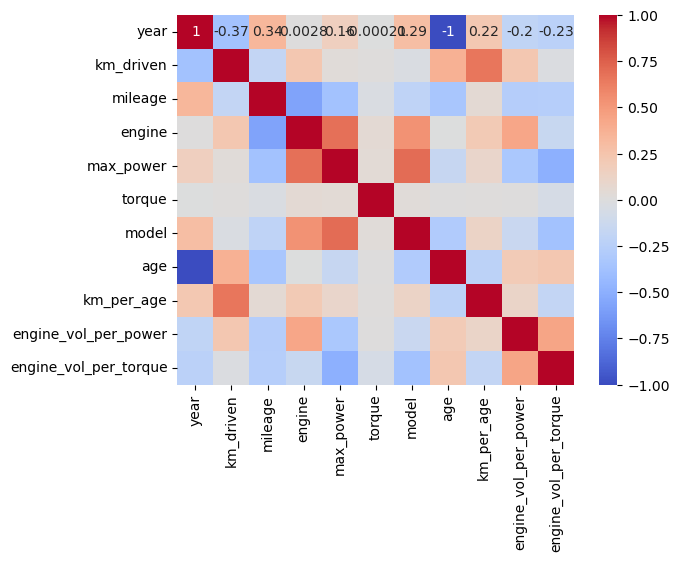

In [76]:
sns.heatmap(X_train_cat_fe_scaled[to_scale].corr(), annot=True, cmap='coolwarm')

In [77]:
X_train_cat_fe_scaled.head()

fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Dealer  \
0         0            1         0            0                   0   
1         0            1         0            0                   0   
2         0            1         0            0                   0   
3         0            0         0            1                   0   
4         0            0         0            1                   0   

   seller_type_Individual  seller_type_Trustmark Dealer  \
0                       1                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       1                             0   

   transmission_Automatic  transmission_Manual  owner_First Owner  \
0                       0                    1                  1   
1                       0                    1                  0   
2                       0                    1                  1   
3                       0                    1                  1   
4                       0                    1                  1   

   owner_Fourth & Above Owner  owner_Second Owner  owner_Test Drive Car  \
0                           0                   0                     0   
1                           0                   1                     0   
2                           0                   0                     0   
3                           0                   0                     0   
4                           0                   0                     0   

   owner_Third Owner  marque_ambassador  marque_audi  marque_bmw  \
0                  0                  0            0           0   
1                  0                  0            0           0   
2                  0                  0            0           0   
3                  0                  0            0           0   
4                  0                  0            0           0   

   marque_chevrolet  marque_daewoo  marque_datsun  marque_fiat  marque_force  \
0                 0              0              0            0             0   
1                 0              0              0            0             0   
2                 0              0              0            0             0   
3                 0              0              0            0             0   
4                 0              0              0            0             0   

   marque_ford  marque_honda  marque_hyundai  marque_isuzu  marque_jaguar  \
0            0             0               0             0              0   
1            0             0               0             0              0   
2            0             0               1             0              0   
3            0             0               0             0              0   
4            0             0               1             0              0   

   marque_jeep  marque_kia  marque_land  marque_lexus  marque_mahindra  \
0            0           0            0             0                0   
1            0           0            0             0                0   
2            0           0            0             0                0   
3            0           0            0             0                0   
4            0           0            0             0                0   

   marque_maruti  marque_mercedes-benz  marque_mg  marque_mitsubishi  \
0              1                     0          0                  0   
1              0                     0          0                  0   
2              0                     0          0                  0   
3              1                     0          0                  0   
4              0                     0          0                  0   

   marque_nissan  marque_peugeot  marque_renault  marque_skoda  marque_tata  \
0              0               0             

In [78]:
# Удалю age т.к. большая мультиколлинеарность с year
X_train_cat_fe_scaled = X_train_cat_fe_scaled.drop('age', axis=1)
X_test_cat_fe_scaled = X_test_cat_fe_scaled.drop('age', axis=1)

In [79]:
model_ridge_fe = Ridge()

params = {
    'alpha': np.linspace(0, 10, 101)
}

grid_search_ridge_fe = GridSearchCV(
    estimator=model_ridge_fe,
    param_grid=params,
    cv=10,
    scoring='neg_mean_squared_error'
)

grid_search_ridge_fe.fit(X_train_cat_fe_scaled, y_train)

print(f'''Лучшие параметры: {grid_search_ridge_fe.best_params_}
Лучшая метрика MSE: {-grid_search_ridge_fe.best_score_:.3f}
Лучшая метрика RMSE: {np.sqrt(-grid_search_ridge_fe.best_score_):.3f}''')

Лучшие параметры: {'alpha': 10.0}
Лучшая метрика MSE: 81210350519.893
Лучшая метрика RMSE: 284974.298


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [v] Реализуйте метрику `business_metric`
- [v] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [80]:
def business_metrics(y_true, y_pred):
    percentage_error = np.abs(y_true - y_pred) / y_true
    less_than_10 = np.mean(percentage_error <= 0.1)
    return less_than_10

models = {
    model_lr: [X_test, y_test, 'model_lr'],
    model_lasso: [X_test, y_test, 'model_lasso'],
    grid_search_elasticnet: [X_test, y_test, 'grid_search_elasticnet'],
    grid_search_ridge: [X_test_cat_scaled, y_test, 'grid_search_ridge'],
    grid_search_ridge_fe: [X_test_cat_fe_scaled, y_test, 'grid_search_ridge_fe']
}

for model, features in models.items():
    X_test = features[0]
    y_test = features[1]
    model_name = features[2]
    preds = model.predict(X_test)
    print(f"{model_name}: {business_metrics(y_test, preds)}")

model_lr: 0.227
model_lasso: 0.227
grid_search_elasticnet: 0.225
grid_search_ridge: 0.272
grid_search_ridge_fe: 0.22


Модель `grid_search_ridge` лучше всего решает задачу по бизнес метрике **0.272**

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [81]:
def your_business_metrics(y_true, y_pred):
    error = y_pred - y_true
    penalty_weights = np.where(error < 0, 2, 1)
    return np.mean(np.abs(error) * penalty_weights)

for model, features in models.items():
    X_test = features[0]
    y_test = features[1]
    model_name = features[2]
    preds = model.predict(X_test)
    print(f"{model_name}: {your_business_metrics(y_test, preds)}")

model_lr: 362049.9329942325
model_lasso: 362049.7441671784
grid_search_elasticnet: 361907.73125223577
grid_search_ridge: 280465.8883513357
grid_search_ridge_fe: 310491.7737921904


# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

In [82]:
num_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power',	'torque']
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'marque', 'seats']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_cat, num_features),
        ('cat', ohe, cat_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', grid_search_ridge)
])

pipeline.fit(df_train, y_train)

with open('app_data.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
